In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
import tinyarray
import argparse
from scipy import linalg as la
from scipy.sparse import linalg as sla
from types import SimpleNamespace
from copy import deepcopy
from utils2 import Regular_Polygon

In [2]:
lat = kwant.lattice.honeycomb(a=1.0, norbs=1)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def make_system(a, shape="ribbon", diminsions=SimpleNamespace(L=10, W=10)):

    def onsite(site, param):
        staggered_pot =  param.m if site.family == a_lat else -param.m
        disorder = param.disorder*kwant.digest.gauss(repr(site), "")
        return (disorder + staggered_pot)
    def hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -1
    
    def nnn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        t_nnn = np.real(param.t_2) + 1j*np.imag(param.t_2)
        return t_nnn

    sys = kwant.Builder()
    if shape == "ribbon":
        for i in range(diminsions.L):
            for j in range(diminsions.W):
                sys[a_lat(i, j)] = onsite
                sys[b_lat(i, j)] = onsite
    elif shape == "rectangle":
        sys[lat.shape(lambda pos: 0<=pos[0]<=diminsions.L and 0<=pos[1]<=diminsions.W, (0, 0))] = onsite
    
    elif shape == "triangular-zz":
        for i in range(diminsions.N_edge):
            for j in range(diminsions.N_edge- i):
                sys[a_lat(i, j)] = onsite
                sys[b_lat(i, j)] = onsite
    
    elif shape == "triangular-ac":
        def armchair_triangle(pos):
            x, y = pos
            y+=1/np.sqrt(3) 
            
            le = x > 0
            be = y >= x/np.sqrt(3) + 0.01
            re = x <= diminsions.l*np.sqrt(3)/2
            ue = y <= diminsions.l - x/np.sqrt(3)
            return le and be and re and ue    
        sys[lat.shape(armchair_triangle, start=(1, 1))] = onsite

    # hexagon
    elif shape == "hexagon-zz":
        for i in range(0, 2*diminsions.Lx):
            if i < diminsions.Lx:
                for j in range(0, diminsions.Lx + 1):
                    sys[a_lat(i, j)] = onsite
                    sys[b_lat(i, j)] = onsite
                    if j > 0:
                        sys[a_lat(i+j, -j)] = onsite
                        sys[b_lat(i+j, -j)] = onsite
            else:
                for j in range(0, diminsions.Lx - (i - diminsions.Lx)):
                    sys[a_lat(i, j)] = onsite
                    sys[b_lat(i, j)] = onsite
                    if j > 0:
                        sys[a_lat(i+j, -j)] = onsite
                        sys[b_lat(i+j, -j)] = onsite
    
    elif shape == "hexagon-ac":
        sys[lat.shape(Regular_Polygon(diminsions.R, n=6, start=np.pi/6), start=(0, 0))] = onsite

    elif shape == "circle":
        sys[lat.shape(lambda pos: np.linalg.norm(pos) < diminsions.r, start=(0, 0))] = onsite
    else:
        raise ValueError(f"Shape {shape} not recognized")
    
    sys[lat.neighbors()] = hopping
    edges = []
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    sites = list(sys.sites())
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 2:
            edges.append(s)

    sys[lat_neighbors_2] = nnn_hopping

    return sys, edges


In [3]:
# attach leads
def add_leads(sys, shape, diminsions, add_second_lead=True):
    sys_with_leads = deepcopy(sys)
    sq_lattice = kwant.lattice.square(a=1.0, norbs=1)
    add_second_lead = True

    if shape == "triangular-zz":    
        # triangle -zz
        added_site =  sq_lattice(0, 1)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 1)
        added_site2 = sq_lattice(diminsions.N_edge-1, 1)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(10, 0)
    elif shape == "triangular-ac":
        # triangle -ac
        added_site = sq_lattice(0, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 1)
        added_site2 = sq_lattice(8, 5)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(5, 5)
    elif shape == "hexagon-zz":
        # hexagon -zz
        added_site = sq_lattice(-1, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 0)
        added_site2 = sq_lattice(2*diminsions.Lx, 0)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(29, 0)
    elif shape == "hexagon-ac":
    # hexagon -ac
        added_site = sq_lattice(-diminsions.R, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(-12, 0)
        added_site2 = sq_lattice(diminsions.R, 0)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(12, 0)
    elif shape == "circle":
    # circle
        added_site = sq_lattice(-diminsions.r, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(-6, 0)
        added_site2 = sq_lattice(diminsions.r, 0)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w  a(6, 0)

    elif shape == "rectangle":
        # rectangle
        added_site = sq_lattice(0, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
        
        added_site2 = sq_lattice(diminsions.L, diminsions.W)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([0, 1]))
            
    else:
        raise ValueError(f"Shape {shape} not recognized for lead attachment")


    w1 = list(sys.sites())[0]
    w2 = list(sys.sites())[-1]
    for s in sys.sites():
        d1 = np.linalg.norm(w1.pos - added_site.pos)
        d2 = np.linalg.norm(w2.pos - added_site2.pos)
        if np.linalg.norm(s.pos - added_site.pos) < d1:
            w1 = s
        if np.linalg.norm(s.pos - added_site2.pos) < d2:
            w2 = s

    _lead1[added_site] = 0
    _lead1[sq_lattice.neighbors(1)] = -3
    sys_with_leads[added_site]  = 0
    sys_with_leads[added_site,  w1] = -3
    sys_with_leads.attach_lead(_lead1)

    if add_second_lead:
        _lead2[added_site2] = 0
        _lead2[sq_lattice.neighbors(1)] = -3
        sys_with_leads[added_site2] = 0
        sys_with_leads[added_site2, w2] = -3
        sys_with_leads.attach_lead(_lead2)


    sys_with_leads_fin = sys_with_leads.finalized()
    return sys_with_leads_fin


def psi_up_dn(sys_fin, energy, params, edges_up, edges_down):
    psi_r = kwant.wave_function(sys_fin, energy=energy, params=params)(0)[0]
    psi_l = kwant.wave_function(sys_fin, energy=energy, params=params)(1)[0]
    if edges_up is not None and edges_down is not None:
        density_up = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site in edges_up)(psi_r)
        density_down = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site in edges_down)(psi_r)
        psi_up_l = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site in edges_up)(psi_l)
        psi_down_l = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site in edges_down)(psi_l)
    else:
        print("No edges provided, using full system for density calculation")
        density_up = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site.pos[1] > site.pos[0])(psi_r)
        density_down = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site.pos[0] > site.pos[1])(psi_r)
        psi_up_l = kwant.operator.Density(sys_fin, sum=True, where=lambda site:  site.pos[1] > site.pos[0])(psi_l)
        psi_down_l = kwant.operator.Density(sys_fin, sum=True, where=lambda site:  site.pos[0] > site.pos[1])(psi_l)
    return density_up, density_down, psi_up_l, psi_down_l

In [10]:
a = 1.0

args1 = SimpleNamespace(
    shape   ="hexagon-zz",

    r       =15,
    Lx      =15,
    L       =30,
    W       =20,
    N_edge  =13,
    R       = 9.5,
    l       = 17,
    
    t_prime =-0.2,
    t_2     =0.0,
    m       =0.0,
    disorder=0.0,
    energy  =0.0
    )

args2 = SimpleNamespace(
    shape   ="hexagon-zz",

    r       =7,
    Lx      =7,
    L       =30,
    W       =20,
    N_edge  =13,
    R       = 9.5,
    l       = 17,
    
    t_prime =-0.2,
    t_2     =0.0,
    m       =0.0,
    disorder=0.0,
    energy  =0.0
)

args3 = SimpleNamespace(
    shape   ="hexagon-zz",

    r       =10,
    Lx      =10,
    L       =30,
    W       =20,
    N_edge  =13,
    R       = 9.5,
    l       = 17,
    
    t_prime =-0.2,
    t_2     =0.0,
    m       =0.0,
    disorder=0.0,
    energy  =0.0
)


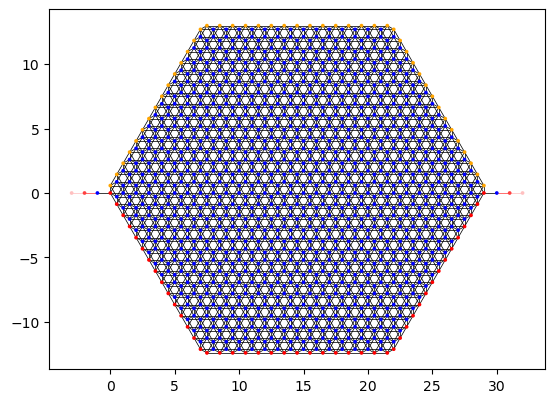

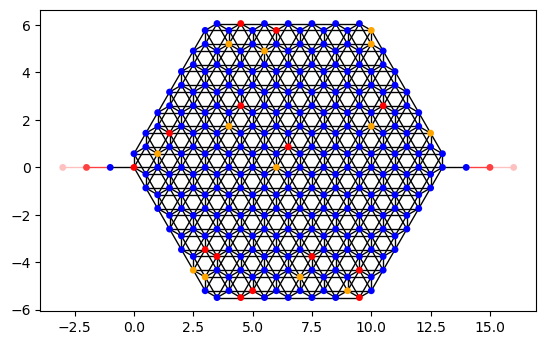

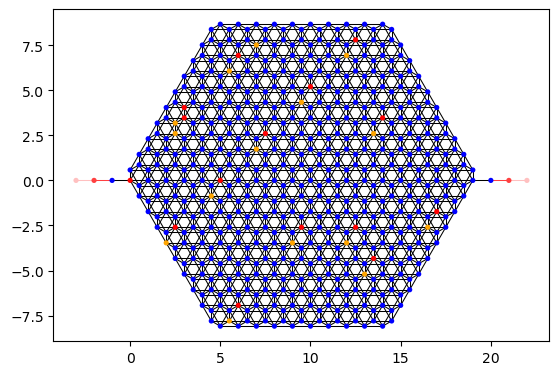

In [12]:

# Define the shape of the system
shapes = ["triangular-zz", "ribbon", "triangular-ac", "hexagon-zz", "hexagon-ac", "circle", "rectangle"]
shape1 = args1.shape
shape2 = args2.shape
shape3 = args3.shape
diminsions1 = SimpleNamespace(r=args1.r, Lx=args1.Lx)
diminsions2 = SimpleNamespace(r=args2.r, Lx=args2.Lx)
diminsions3 = SimpleNamespace(r=args3.r, Lx=args3.Lx)

# Create the system
sys1, edges1 = make_system(a, shape1, diminsions1)
sys2, edges2 = make_system(a, shape2, diminsions2)
sys3, edges3 = make_system(a, shape3, diminsions3)

edges_up1 = [s for s in edges1 if s.pos[1] > 0]
edges_down1 = [s for s in edges1 if s.pos[1] <= 0]
edges_up2 = [s for s in edges2 if s.pos[1] > 0]
edges_down2 = [s for s in edges2 if s.pos[1] <= 0]
edges_up3 = [s for s in edges3 if s.pos[1] > 0]
edges_down3 = [s for s in edges3 if s.pos[1] <= 0]

# if shape == "triangular-zz":
#     min_y = min(s.pos[1] for s in edges_up)
#     edges_up = []
#     edges_down = []
#     for s in edges:
#         if np.abs(s.pos[1] - min_y)<0.5: edges_down.append(s)
#         else: edges_up.append(s)
# elif shape == "rectangle":
#     edges_up = []
#     edges_down = []
#     # for s in edges: # I changed this to consider all sites, not just edges
#     for s in sys.sites():
#         if s.pos[1]*args.L > s.pos[0]*args.W: edges_up.append(s)
#         else: edges_down.append(s)



sys_with_leads_fin1 = add_leads(sys1, shape1, diminsions1)
sys_with_leads_fin2 = add_leads(sys2, shape2, diminsions2)
sys_with_leads_fin3 = add_leads(sys3, shape3, diminsions3)


def color_edges(site):
    site = sys_with_leads_fin1.sites[site]
    if site in edges_up1:
        return 'orange'
    elif site in edges_down1:
        return 'red'
    else:
        return 'blue'
kwant.plot(sys_with_leads_fin1, site_size=0.25, show=False, site_color=color_edges)
kwant.plot(sys_with_leads_fin2, site_size=0.25, show=False, site_color=color_edges)
kwant.plot(sys_with_leads_fin3, site_size=0.25, show=False, site_color=color_edges)
plt.show()


In [13]:
energies = np.linspace(-1, 1.001, 251)
transmissions1 = []
conductance1 = []
transmissions2 = []
conductance2 = []
transmissions3 = []
conductance3 = []
params1 = dict(param=SimpleNamespace(
    t_2=1j * args1.t_prime + args1.t_2,
    m=args1.m,
    disorder=args1.disorder,
))
params2 = dict(param=SimpleNamespace(
    t_2=1j * args2.t_prime + args2.t_2,
    m=args2.m,
    disorder=args2.disorder,
))
params3 = dict(param=SimpleNamespace(
    t_2=1j * args3.t_prime + args3.t_2,
    m=args3.m,
    disorder=args3.disorder,
))
for energy in energies:
    smatrix1 = kwant.smatrix(sys_with_leads_fin1, energy, params=params1)
    T1 = smatrix1.transmission(0, 1)
    transmissions1.append(T1)
    u_r1, d_r1, u_l1, d_l1 = psi_up_dn(sys_with_leads_fin1, energy, params1, edges_down=edges_down1, edges_up=edges_up1)
    conductance1.append(T1 * np.abs((u_r1 + u_l1)*(d_r1 + d_l1)/(u_l1*d_r1 - u_r1*d_l1)))
    smatrix2 = kwant.smatrix(sys_with_leads_fin2, energy, params=params2)
    T2 = smatrix2.transmission(0, 1)
    transmissions2.append(T2)
    u_r2, d_r2, u_l2, d_l2 = psi_up_dn(sys_with_leads_fin2, energy, params2, edges_down=edges_down2, edges_up=edges_up2)
    conductance2.append(T2 * np.abs((u_r2 + u_l2)*(d_r2 + d_l2)/(u_l2*d_r2 - u_r2*d_l2)))
    smatrix3 = kwant.smatrix(sys_with_leads_fin3, energy, params=params3)
    T3 = smatrix3.transmission(0, 1)
    transmissions3.append(T3)
    u_r3, d_r3, u_l3, d_l3 = psi_up_dn(sys_with_leads_fin3, energy, params3, edges_down=edges_down3, edges_up=edges_up3)
    conductance3.append(T3 * np.abs((u_r3 + u_l3)*(d_r3 + d_l3)/(u_l3*d_r3 - u_r3*d_l3)))
    

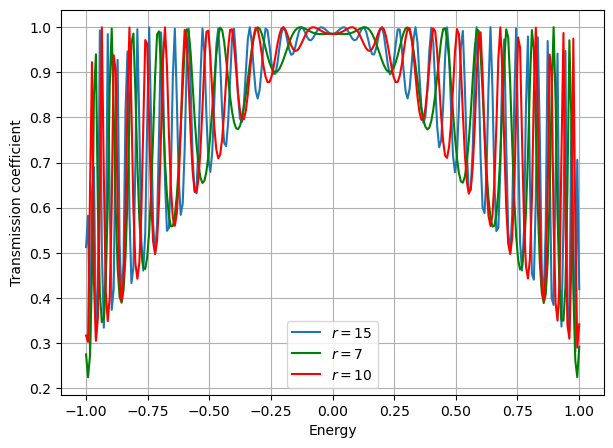

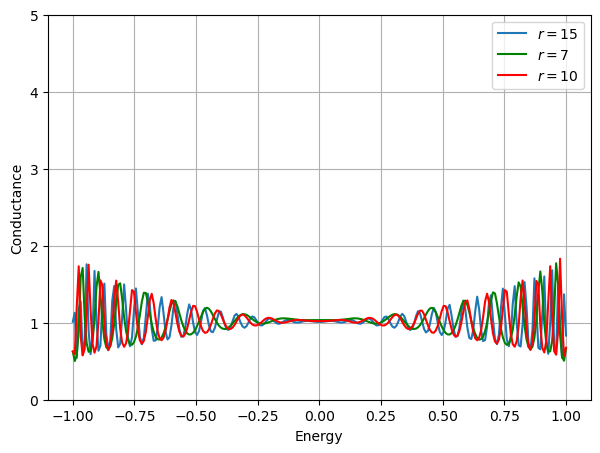

In [14]:
plt.figure(figsize=(7, 5))
plt.plot(energies, transmissions1, label=r"$r=15$")
plt.plot(energies, transmissions2, label=r"$r= 7$", color='green')
plt.plot(energies, transmissions3, label=r"$r= 10$", color='red')
plt.xlabel("Energy")
plt.ylabel("Transmission coefficient")
# plt.title("Transmission vs Energy")
plt.legend()
plt.grid(True)
plt.show()
# plt.plot(energies, energies + 0.47)
plt.figure(figsize=(7, 5))
plt.plot(energies, conductance1, label=r"$r=15$")
plt.plot(energies, conductance2, label=r"$r= 7$", color='green')
plt.plot(energies, conductance3, label=r"$r= 10$", color='red')
plt.xlabel("Energy")
plt.ylabel("Conductance")
plt.ylim(0, 5.0)
# plt.title("Conductance vs Energy")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
t_primes = 0.001*np.power(1/0.001, np.array(range(201))/200)


transmissions_soc1 = []
conductance_soc1 = []
transmissions_soc2 = []
conductance_soc2 = []
transmissions_soc3 = []
conductance_soc3 = []

for t_prime_ in t_primes:
    params1 = dict(param=SimpleNamespace(
        t_2=1j * t_prime_ + args1.t_2,
        m=args1.m,
        disorder=args1.disorder,
    ))
    params2 = dict(param=SimpleNamespace(
        t_2=1j * t_prime_ + args2.t_2,
        m=args2.m,
        disorder=args2.disorder,
    ))
    params3 = dict(param=SimpleNamespace(
        t_2=1j * t_prime_ + args3.t_2,
        m=args3.m,
        disorder=args3.disorder,
    ))
    smatrix1 = kwant.smatrix(sys_with_leads_fin1, args1.energy-args1.t_2 +args1.m/2, params=params1)
    T1 = smatrix1.transmission(0, 1)
    transmissions_soc1.append(T1)
    u_r1, d_r1, u_l1, d_l1 = psi_up_dn(sys_with_leads_fin1, args1.energy-args1.t_2 +args1.m/2, params1, edges_down=edges_down1, edges_up=edges_up1)
    conductance_soc1.append(T1 * np.abs((u_r1 + u_l1)*(d_r1 + d_l1)/(u_l1*d_r1 - u_r1*d_l1)))
    smatrix2 = kwant.smatrix(sys_with_leads_fin2, args2.energy-args2.t_2 +args2.m/2, params=params2)
    T2 = smatrix2.transmission(0, 1)
    transmissions_soc2.append(T2)
    u_r2, d_r2, u_l2, d_l2 = psi_up_dn(sys_with_leads_fin2, args2.energy-args2.t_2 +args2.m/2, params2, edges_down=edges_down2, edges_up=edges_up2)
    conductance_soc2.append(T2 * np.abs((u_r2 + u_l2)*(d_r2 + d_l2)/(u_l2*d_r2 - u_r2*d_l2)))
    smatrix3 = kwant.smatrix(sys_with_leads_fin3, args3.energy-args3.t_2 +args3.m/2, params=params3)
    T3 = smatrix3.transmission(0, 1)
    transmissions_soc3.append(T3)
    u_r3, d_r3, u_l3, d_l3 = psi_up_dn(sys_with_leads_fin3, args3.energy-args3.t_2 +args3.m/2, params3, edges_down=edges_down3, edges_up=edges_up3)
    conductance_soc3.append(T3 * np.abs((u_r3 + u_l3)*(d_r3 + d_l3)/(u_l3*d_r3 - u_r3*d_l3)))
    


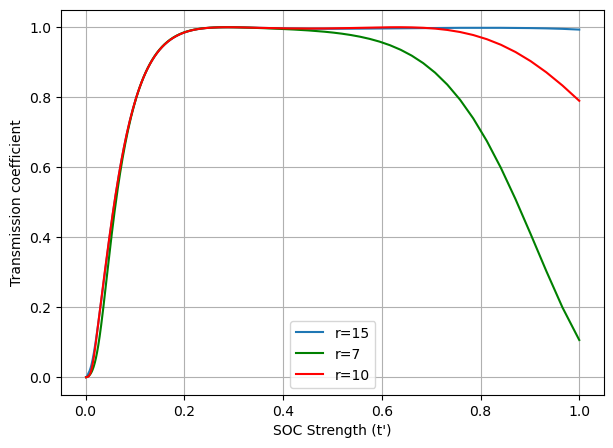

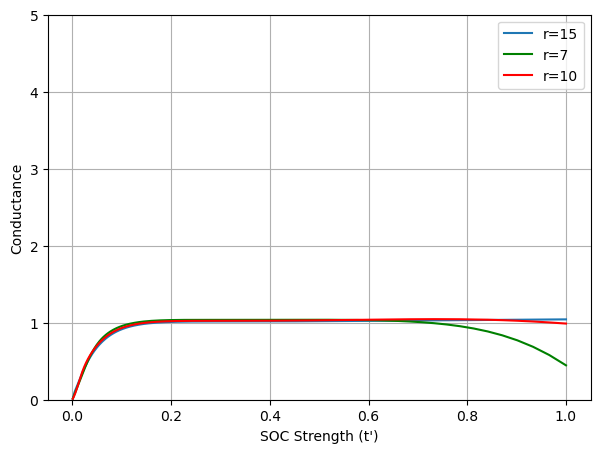

In [16]:

plt.figure(figsize=(7, 5))
plt.plot(t_primes, transmissions_soc1, label="r=15")
plt.plot(t_primes, transmissions_soc2, label="r=7", color='green')
plt.plot(t_primes, transmissions_soc3, label="r=10", color='red')
plt.xlabel("SOC Strength (t')")
plt.ylabel("Transmission coefficient")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(t_primes, conductance_soc1, label="r=15")
plt.plot(t_primes, conductance_soc2, label="r=7", color='green')
plt.plot(t_primes, conductance_soc3, label="r=10", color='red')
plt.xlabel("SOC Strength (t')", fontsize=10)
plt.ylabel("Conductance")
plt.ylim(0, 5)
plt.legend()
plt.grid(True)
plt.show()